<a href="https://colab.research.google.com/github/m-aliabbas/MedicalImageClassification/blob/master/LC25000FastAI18Colon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1721      0 --:--:-- --:--:-- --:--:--  1721
Updating fastai...
Done.


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
unZip('drive/My Drive/Dropbox/LC25000.zip')

Done!


In [0]:
import glob
import cv2
import numpy as np
files1= sorted(glob.glob('lung_colon_image_set/lung_image_sets/lung_n/*.jpeg'))
files2= sorted(glob.glob('lung_colon_image_set/lung_image_sets/lung_scc/*.jpeg'))
files3= sorted(glob.glob('lung_colon_image_set/lung_image_sets/lung_aca/*.jpeg'))
files4= sorted(glob.glob('lung_colon_image_set/colon_image_sets/colon_n/*.jpeg'))
files5= sorted(glob.glob('lung_colon_image_set/colon_image_sets/colon_aca/*.jpeg'))


In [0]:
labels1=[[i,0] for i in files4]
labels2=[[i,1] for i in files5]



ds=labels1+labels2

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=True,test_size=0.25, random_state=42)

In [0]:
bs =32
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=2) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
data.classes

[0, 1]

In [0]:

import torch 
import torchvision
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
num_ftrs = model.fc.in_features
model.fc=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.5),
    nn.Linear(128, len(data.classes)),
    
)

In [0]:
model=model.cuda()

In [0]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy])

In [0]:
from fastai.callbacks import *
learn.fit(4,lr=0.00001)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.132568,0.031632,0.001333,0.998667,03:34
1,0.050206,0.008882,0.000000,1.000000,03:34
2,0.022968,0.002984,0.000000,1.000000,03:38
3,0.010851,0.001484,0.000000,1.000000,03:39


In [0]:
learn.unfreeze()

In [0]:
learn.fit(4,lr=0.00001)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.011820,0.000795,0.000000,1.000000,03:40
1,0.009394,0.000631,0.000000,1.000000,03:38
2,0.003706,0.000319,0.000000,1.000000,03:37
3,0.003688,0.000245,0.000000,1.000000,03:35


In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
learn.data.valid_dl = data.train_dl

Precision of Model = 1.0 Recall of Model  1.0
F1 Score of Model = 1.0


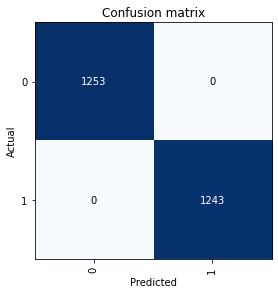

In [0]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
from sklearn import metrics

In [0]:
preds,y, loss = learn.get_preds(with_loss=True)

In [0]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 1.0


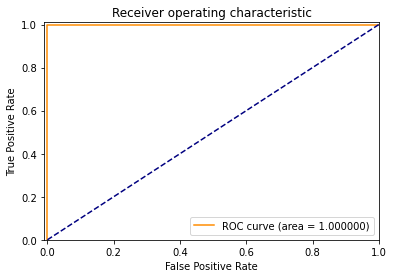

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")